# Exploring heavylight.Tables

This document provides a walkthrough of `Table` features, including examples showing the dynamics.

## What is the `Table` class?

The Table class provides an efficient way to store and lookup values in actuarial tables, including tables with more than one key, and tables with interval based keys.  The table is stored in *long* format, that is, each unique key stores a single value.

Using the `Table` is completely optional, and it can be used for other purposes as well as within heavylight Models.  You may find that Python dictionaries, classes, or pandas dataframes work better for certain use cases.  Challenges on use cases are welcome, please post a new issue on [GitHub](https://github.com/lewisfogden/heavylight/issues) 

### Keys

`Table` determines the type of key column based on the column name suffix, the following are supported:

- `|int`: integers (...0, 1, 2, 3...), can start and end anywhere, but must be consecutive
- `|int_bound`: as `|int` but any values are constrained to the lowest and highest values.
- `|int_cat`: integer are interpreted as categories, e.g. frequencies of 1, 3, 6, 12 months.
- `|str`: keys are interpreted as strings, e.g. 'M' and 'F'
- `|band`: key is numeric and treated as the upper bound on a lookup.


### Creating a Table

Below table has an example of the input structure for creating a table, which has 3 keys (age, dur, product) and one value:

| age\|int | dur\|int_bound | product\|str | value\|float |
|:--------:|:--------------:|:------------:|:------------:|
|  20      |  0             |  DTA         |  0.03        |
|  21      |  0             |  DTA         |  0.04        |
|  ...     |  ...           |  ....        |  ...         |

Note that the `value` type (`|float`) is not currently used/implemented, however we recommend using this to document the type of the value, and if a future implementation includes value type validation.

Tables are typically created from dataframes, for convenience a `read_excel` and `read_csv` methods are included which will work for correctly prepared tables.

#### Initialising using `Table()`

```python
table = Table(df, rectify=False, safe=True)
```
This has the following arguments:

  - `df`: The pandas dataframe to be loaded in, which should follow the rules outlined above in terms of keys and values.  Any index columns in the dataframe will be ignored.

  - *optional* `rectify`: If `True` then this will attempt to ensure that the dataframe is rectangular, through filling out any missing values.  The default `False` will cause an error to be raised if the dataframe isn't rectangular.  A *rectangular* dataframe is one where a value is defined for each combination of keys in each of the key columns.
  
  - *optional* `safe`: If `True` then any `|int` keys will be automatically tested to ensure they are within the lower and upper bounds, with an exception being raised if any values fall outside the interval.  Keys of type `int_bound` are automatically safe.


#### Initialising using `Table.read_excel` and `Table.read_csv`

```python
Table.read_excel(spreadsheet_path, sheet_name)
```

This has the following arguments:

  - `spreadsheet_path`: a string or pathlib.Path object pointing to the spreadsheet, for example: `C:\path\to\basis.xlsx`
  - `sheet_name`: the name of the worksheet within the workbook, for example: `mortality_table`.  `read_excel` will attempt to read all data in this sheet to the table.

If you have more complicated spreadsheets (for example offset/named ranges), you may need to write your own reader to prepare the dataframe and use the `Table()` constructor.

You may need to install `openpyxl` or another python Excel library in order to use this constructor.

```python
Table.read_csv(csv_path)
```

This will aim to create a dataframe by using `pandas.read_csv`.  For more complicated csv files, including non-standard separators, using `pandas.read_<type>` is recommended.

This has the following argument:
  - `csv_path`: the path to the csv file.

The following examples are intended to illustrate the above.

In [18]:
from heavylight import Table
import numpy as np
import pandas as pd
import seaborn as sns
import heavylight
print(f"Version: {heavylight.__version__ = }")

Version: heavylight.__version__ = '1.0.10'


## Example 1: Simple Table

Tables can be created directly from pandas dataframes, or from csv files or excel spreadsheet.

Here we create a dataframe table, with key `x` being an integer key, and floating point values.

In [2]:
df1 = pd.DataFrame({
    'x|int': np.arange(20, 51),
})
df1['value|float'] = df1['x|int'] * 0.04 - 0.03
df1.tail()

x|int  value|float
26     46         1.81
27     47         1.85
28     48         1.89
29     49         1.93
30     50         1.97

We can pass the dataframe in as the contructor to the class.

In [3]:
tab1 = Table(df1)

Querying a single value from the table just involves using array `[]` notation.

In [4]:
print(tab1[20])
print(tab1[20] - (20*0.04 - 0.03))    # this should equal zero

0.77
0.0


We can query multiple results by passing in a numpy array.  (if not a numpy array then convert first using `np.array`).

In [5]:
x1s = np.array([30, 20, 20, 50])
tab1[x1s]

array([1.17, 0.77, 0.77, 1.97])

## Example 2: String key

In [6]:
df2 = pd.DataFrame(
    {
        'x|str':['A', 'B', 'C'],
        'value|float': [0.3, 0.5, 0.9]
    }
)
df2

x|str  value|float
0     A          0.3
1     B          0.5
2     C          0.9

In [7]:
tab2 = Table(df2)

In [8]:
tab2['A']

0.3

In [9]:
tab2['B']

0.5

**Warning**: Note that the string lookup implementation currently uses a binary insertion algorithm, this means that you may get a false positive if you query a non-existent string.   For string lookups you should ensure you have validated data for consistency with assumptions, or consider converting to using integer keys for categories.  (e.g. `Male` -> 0, `Female` -> 1)

This may be fixed in a future version of heavylight.

In [17]:
try:
    tab2['AB']   # key doesn't exist
except KeyError as err:
    print(repr(err))

KeyError('invalid string key(s) passed into table lookup.')


Again, we can lookup up an array of keys and obtain an array of values.

In [ ]:
x2s = np.array(['A', 'A', 'C', 'B'])
tab2[x2s]

array([0.3, 0.3, 0.9, 0.5])

Note that if the key doesn't exist and it is greater than the largest value, then an error will correctly be returned.

In [ ]:
try:
    tab2['Z']
except Exception as err:
    print(repr(err))

IndexError('index 3 is out of bounds for axis 0 with size 3')


## Example 3: Banded Key

Often we may want to get a value for a range of inputs, for example if a fee applies to a range of fund values, or reinsurance rates are set by sum assured bands.

We can assign one or more band tables using the `|band` suffix, which specifies the upper bound for that band.

The interval is open on the left, closed on the right, i.e. $(B-1, B]$ with the first band being $[-\infty, B]$.  For an open ended final band, `np.inf` or a significantly high number should be chosen.

In [ ]:
df3 = pd.DataFrame({
    'age_to|band': np.array([20, 30, 40, 60, 90, 130, np.inf]),
})
df3['value|str'] = df3['age_to|band'].map(lambda i: f'age_to_{i:03.0f}')
df3

age_to|band   value|str
0         20.0  age_to_020
1         30.0  age_to_030
2         40.0  age_to_040
3         60.0  age_to_060
4         90.0  age_to_090
5        130.0  age_to_130
6          inf  age_to_inf

Create a table (again, passing the dataframe in is sufficient)

In [ ]:
tab3 = Table(df3)

We can look up any floating point value, and it will return the band it is contained within:

In [ ]:
tab3[18.5]

'age_to_020'

In [ ]:
tab3[20]

'age_to_020'

In [ ]:
tab3[20.00000001]

'age_to_030'

In [ ]:
# there is no lower bound (generally because the bands will be currency)
tab3[-5]

'age_to_020'

In [ ]:
# there is an upper bound, and will error if over this
try:
    print(tab3[131])
except Exception as err:
    print(repr(err))

age_to_inf


In [ ]:
x3s = np.linspace(35, 45, 14)
pd.DataFrame({'x3s':x3s, 'result':tab3[x3s]})

x3s      result
0   35.000000  age_to_040
1   35.769231  age_to_040
2   36.538462  age_to_040
3   37.307692  age_to_040
4   38.076923  age_to_040
5   38.846154  age_to_040
6   39.615385  age_to_040
7   40.384615  age_to_060
8   41.153846  age_to_060
9   41.923077  age_to_060
10  42.692308  age_to_060
11  43.461538  age_to_060
12  44.230769  age_to_060
13  45.000000  age_to_060

## Example 4: Bounded Integer

If we are dealing with integer keys, sometimes we want the last key to be used for all higher values, for example in a mortality table with a 5 year select period, for durations 5+ we want to use the 5 year duration rate.  This can be accomplished by specifying the key column as a bounded integer: `|int_bound`.  When specified, this applies both on the lower and upper bounds.

In [ ]:
df4 = pd.DataFrame({
    'term|int_bound': [5, 6, 7, 8, 9, 10],
    'rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
})
df4

term|int_bound  rate
0               5  0.05
1               6  0.06
2               7  0.07
3               8  0.08
4               9  0.09
5              10  0.10

In [ ]:
tab4 = Table(df4)

<Axes: >

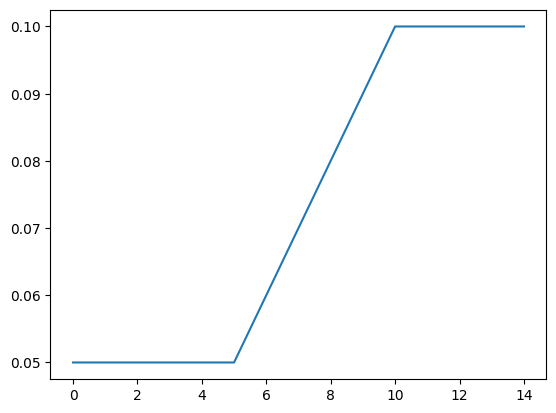

In [ ]:
x4s = np.arange(0, 15)
sns.lineplot(x=x4s, y=tab4[x4s], markers=True)

## Example 5: Two keys are better than one

Tables often have multiple dimensions, e.g. Income Protection recovery rates vary by age, duration etc.  `Table` deals with these the same way as the one dimensional case.

In [ ]:
df5 = pd.DataFrame({
    'age|int_bound': np.tile(np.arange(20, 41), 5),
    'dur|int_bound': np.repeat(np.arange(1, 6), (41-20))
})
df5['values'] = df5['age|int_bound'] * 0.01 + 1.32 ** df5['dur|int_bound']
df5

age|int_bound  dur|int_bound    values
0               20              1  1.520000
1               21              1  1.530000
2               22              1  1.540000
3               23              1  1.550000
4               24              1  1.560000
..             ...            ...       ...
100             36              5  4.367464
101             37              5  4.377464
102             38              5  4.387464
103             39              5  4.397464
104             40              5  4.407464

[105 rows x 3 columns]

In [ ]:
tab5 = Table(df5)

We can lookup the keys by passing in comma separated values

In [ ]:
tab5[104, 40]

4.4074642432000015

Like the one dimensional case, we can pass in numpy arrays of values to each key, to obtain an array of results:

In [ ]:
x5_age = np.array([20, 20, 40, 30, 0, 9999])
x5_dur = np.array([1, 2, 3, 5, -2, 9999])
tab5[x5_age, x5_dur]

array([1.52      , 1.9424    , 2.699968  , 4.30746424, 1.52      ,
       4.40746424])

## Example 6: Error: Tables need to be complete

If using more than one dimension, the table needs to be complete, i.e. len(key 1) x len(key 2) x len(key 3) == len(table).

This is tested at table construction time.



In [ ]:
df6 = pd.DataFrame({
    'k1|int': [1, 2, 3, 4, 1, 2],
    'k2|str': list('AAAABB'),
    'values': [1, 2, 3, 4, 11, 22]
})
df6

k1|int k2|str  values
0       1      A       1
1       2      A       2
2       3      A       3
3       4      A       4
4       1      B      11
5       2      B      22

In [ ]:
# This will trigger a value error

try:
    tab6 = Table(df6)
except Exception as err:
    print(repr(err))

ValueError('Input `df` is not rectangular, expected_rows=8 != len(self.values)=6')


We can attempt ensure tables are rectangular by using the `rectify` parameter.  This may not work if the table is sufficiently complex.  In some cases you may prefer to split the table into several tables.

In [ ]:
tab6b = Table(df6, rectify=True)

Keys with values are looked up as expected:

In [ ]:
tab6b[1, 'A']

1.0

Keys which aren't specified (i.e. `3, 'B'` and `4, 'B'`) return `np.nan`:

In [ ]:
tab6b[4, 'B']

nan

Examples for the `read_csv` and `read_excel` methods are not included here, as they depend on the availability of suitable files.

## Example 7: Integer Category Keys

*Added in v1.0.10*.  `|int` and `|int_bound` both assume integer keys are consecutive integers.  `int_cat` allows for arbitrary integer keys.  This is likely slower to evaluate, so it may be worthwhile considering encoding to integers directly, particularly as categories are all likely to be fed from data.  (e.g. 4,6,10 -> 0, 1, 2)

In [11]:
df7 = pd.DataFrame({
    'deferred_period|int_cat': [1, 4, 12, 26, 52],
    'values|str': ['one week', 'one month', 'three months', 'six months', 'one year']
})
df7

deferred_period|int_cat    values|str
0                        1      one week
1                        4     one month
2                       12  three months
3                       26    six months
4                       52      one year

In [12]:
tab7 = Table(df7)

In [13]:
tab7

   deferred_period|int_cat    values|str
0                        1      one week
1                        4     one month
2                       12  three months
3                       26    six months
4                       52      one year

In [14]:
tab7[4]

'one month'

In [16]:
try:
    tab7[5]
except KeyError as err:
    print(repr(err))

KeyError('invalid integer category key(s) passed into table lookup.')
